In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
from pathlib import Path
import sys
import yaml
import matplotlib.pyplot as plt
sys.path.append("../../")

In [4]:
from pytorch_toolbox.pipeline import PipelineGraph
from pytorch_toolbox.fastai_extensions.vision.utils import tensor2img
from src.train_with_template import lookups
from src.image import plot_rgby

#### Load the configuration file needed to construct the DAG for the pipeline

In [5]:
# CONFIG_FILE = Path("../configs/se_resnext50_32x4d_two_input_fc_template.yml")
CONFIG_FILE = Path("../configs/densenet121_two_input_fc_with_tta_template_pretrained_image_net.yml")

In [6]:
with CONFIG_FILE.open("r") as f:
    config = yaml.load(f)

In [7]:
pipeline_graph = PipelineGraph.create_pipeline_graph_from_config(config)

In [8]:
pipeline_graph.sorted_node_names

['CreateLovaszHingeFlatLoss',
 'CreateSoftF1Loss',
 'CreateFocalLoss',
 'CreateFocalLossMetric',
 'CreateF1SoftMetric',
 'CreateAccuracyMetric',
 'CreateModel',
 'CreateResultRecorder',
 'CreateFiveCropTTAPredictionCallback',
 'CreateGradientClippingLearnerCallback',
 'CreateLabelExtractorCallback',
 'CreateCallbacksForInference',
 'CreateLearnerForInference',
 'CreateCallbacks',
 'CreateTimeStampedSavePath',
 'RunRecordResults',
 'SaveConfiguration',
 'CreateCSVLoggerLearnerCallback',
 'CreateSaveModelCallback',
 'CreateTrainingScheme',
 'CreateSamplerFunction',
 'CreateSampler',
 'CreateDenormalizeFunction',
 'CreateOutputRecorderLearnerCallback',
 'CreateLearnerCallbacks',
 'CreateLearner',
 'CreateNormalizeFunction',
 'CreateFiveCropTTAFunction',
 'CreateTestAugmentationFunction',
 'CreateAugmentationFunction',
 'CreateOpenImageFunction',
 'CreateTestingDataset',
 'CreateDataBunchForInference',
 'CreateInference',
 'CreateValidationDataset',
 'CreateTrainingDataset',
 'LoadTraining

#### Get the nodes needed to create the learner

In [9]:
pipeline_graph.run(lookups, to_node="CreateDataBunch")

In [10]:
create_data_splitter = pipeline_graph.get_node_output("CreateDataSplitter")
create_data_bunch = pipeline_graph.get_node_output("CreateDataBunch")
create_learner = pipeline_graph.get_node_output("CreateLearner")
denormalize_fn = pipeline_graph.get_node_output("CreateDenormalizeFunction")

In [11]:
train_idx, val_idx = next(iter(create_data_splitter()))

In [ ]:
data_bunch = create_data_bunch(train_idx, val_idx)

#### Uncomment below to see the output of the data loader

In [ ]:
data_bunch

DataBunch;
Train: <src.data.ProteinClassificationDataset object at 0x7f453359a208>;
Valid: <src.data.ProteinClassificationDataset object at 0x7f453359a518>;
Test: <src.data.ProteinClassificationDataset object at 0x7f453359a320>

In [ ]:
train_image_batch, _ = next(iter(data_bunch.train_dl))

In [ ]:
train_image = train_image_batch[0]

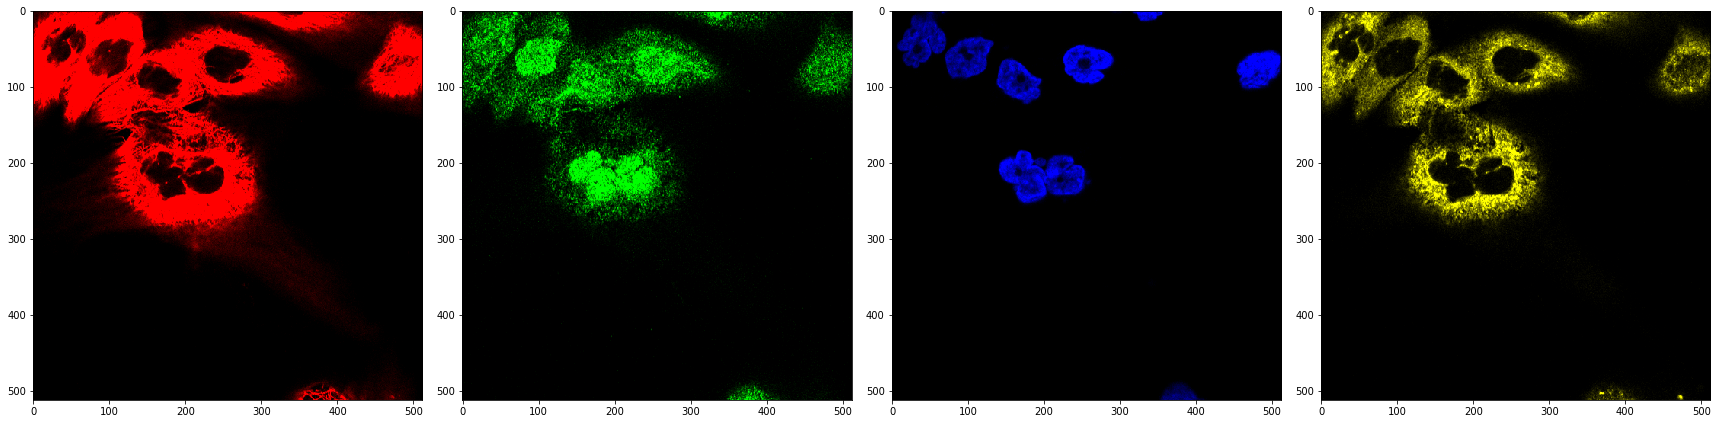

In [ ]:
plot_rgby(tensor2img(train_image, denormalize_fn=denormalize_fn))

In [ ]:
five_crop_images, _ = next(iter(data_bunch.valid_dl))

In [ ]:
five_crop_image = five_crop_images[0]

In [ ]:
five_crop_image.shape

torch.Size([5, 4, 512, 512])

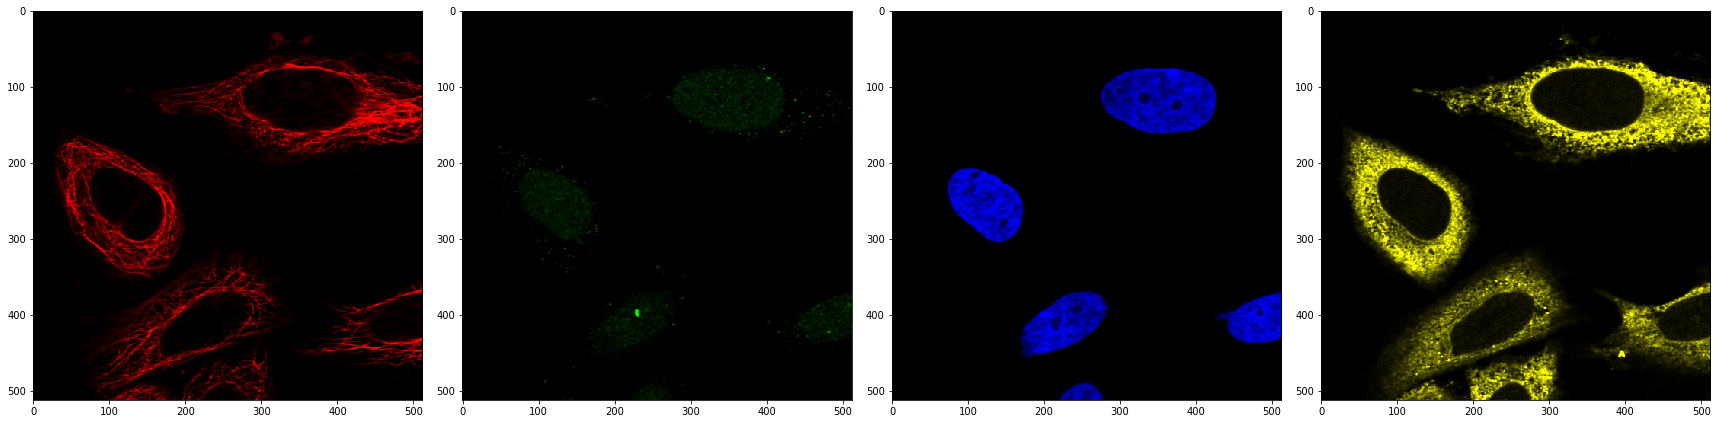

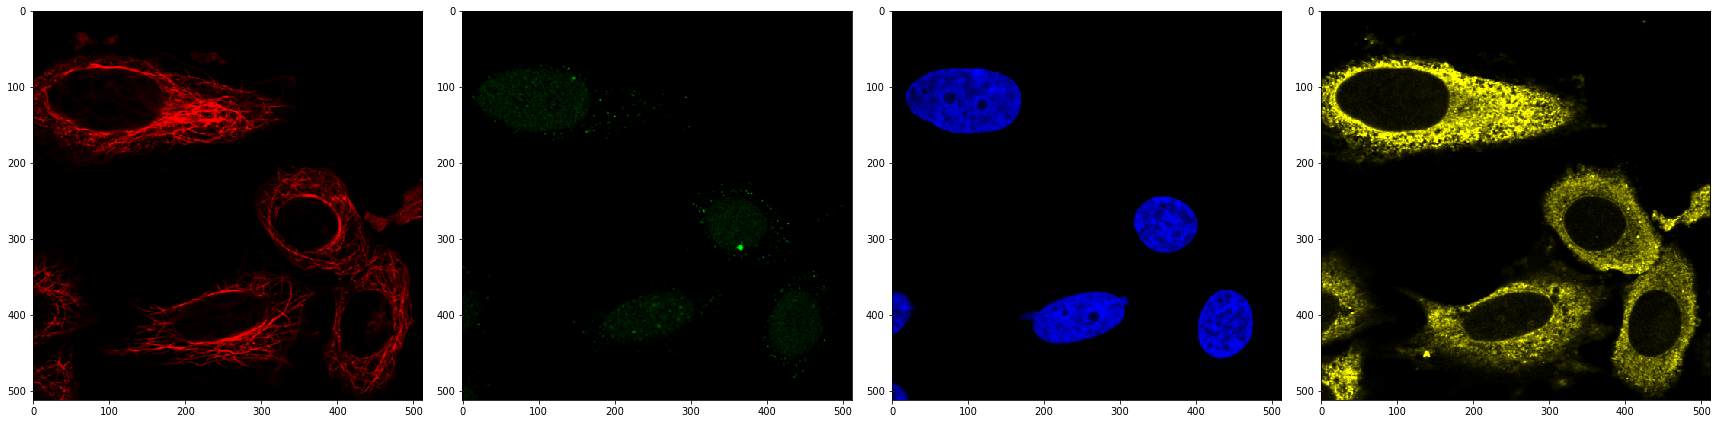

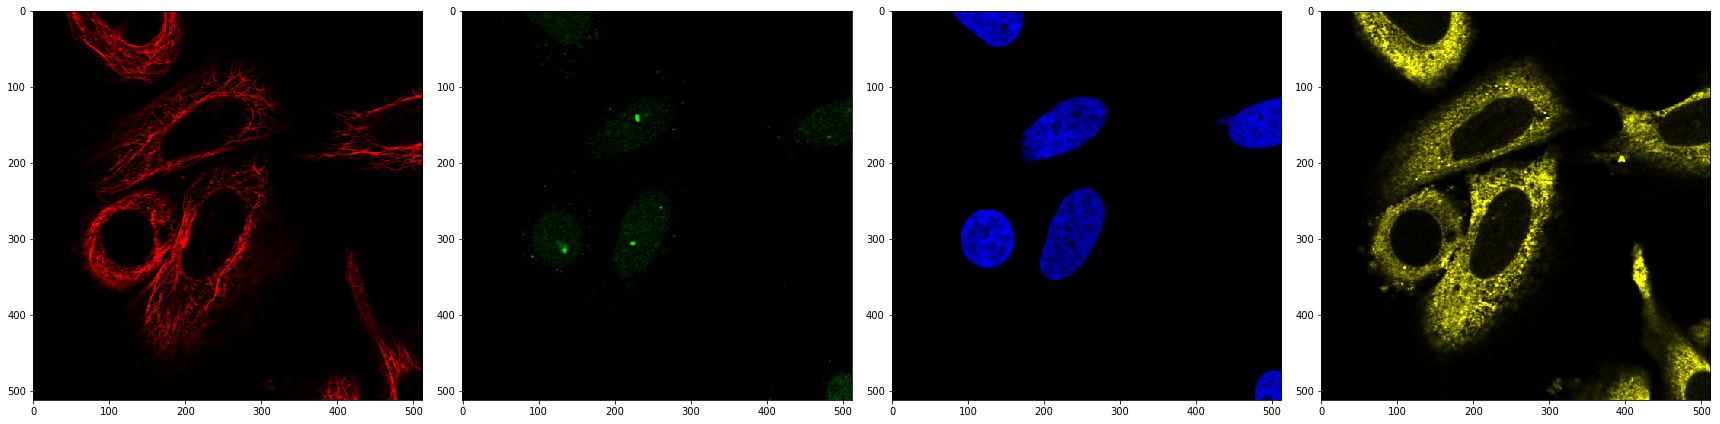

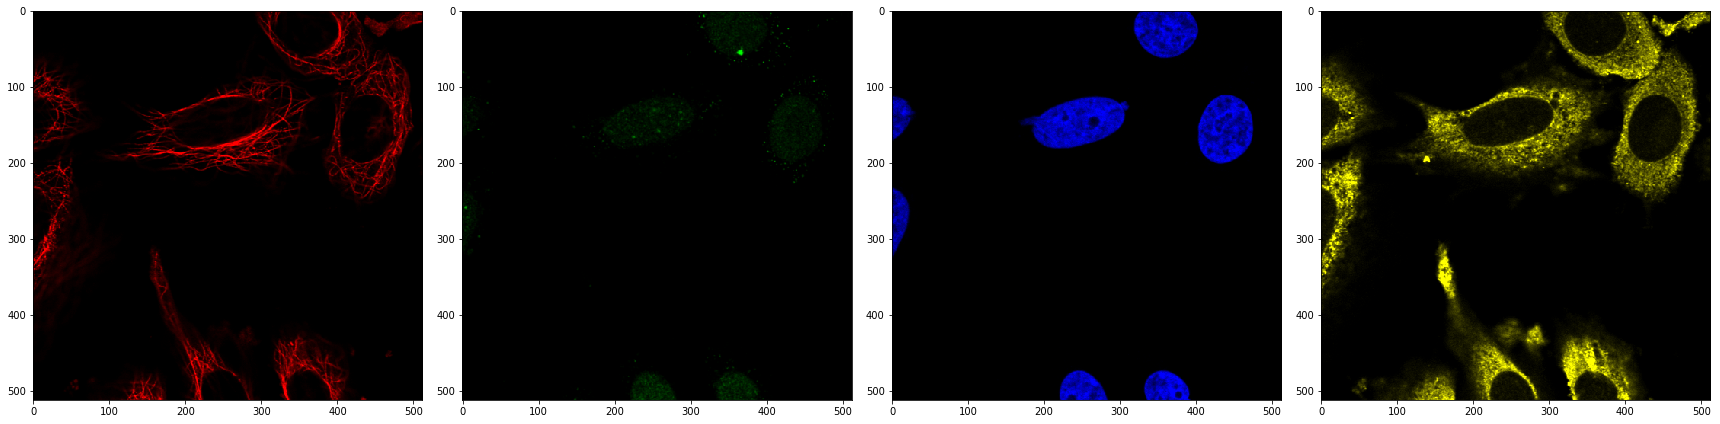

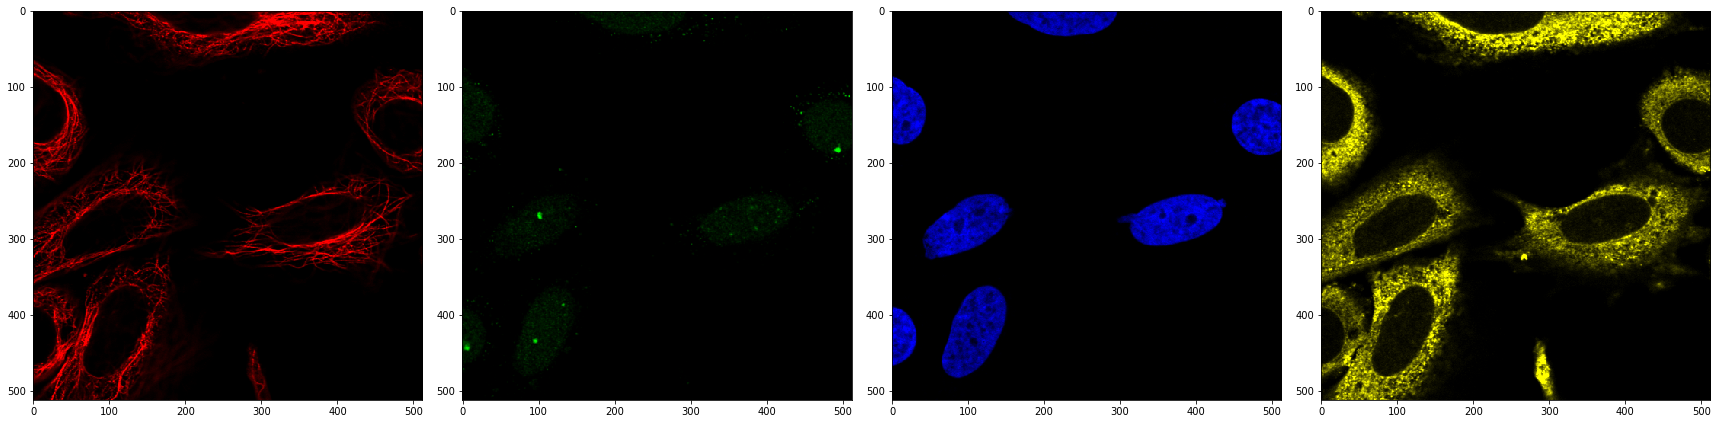

In [ ]:
for crop in five_crop_image:
    plot_rgby(tensor2img(crop, denormalize_fn=denormalize_fn))

#### Find the optimal learning rate

In [ ]:
N_ITERS = 333

In [ ]:
learner = create_learner(data_bunch)
learner.lr_find(num_it=N_ITERS)
learner.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f1_soft,focal_loss


In [ ]:
learner.callbacks